In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import grad
from scipy.integrate import odeint

torch.manual_seed(1234)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

## Data Generation

In [3]:
# Initial conditions (from the literature)
N = 59e6 #population size

S0 = N - 2 #everyone starts out as susceptible, except for 1 person that is infected
I0 = 1 #1 infected person
D0 = 0
R0 = 0

# A grid of time points (in days)
t = np.linspace(0, 500, 100) #from day 0 to day 500, generate 100 points

#parameters (from the literature)
alpha = 0.191
beta = 0.05
gamma = 0.0294

In [4]:
# The SIR model differential equations.
def deriv(y, t, alpha, betta, gamma):
    S, I, D, R = y
    dSdt = - (alpha / N) * S * I
    dIdt = (alpha / N) * S * I - beta * I - gamma * I 
    dDdt = gamma * I
    dRdt = beta * I

    return dSdt, dIdt, dDdt, dRdt

In [5]:
# Initial conditions vector
y0 = S0, I0, D0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(alpha, beta, gamma))
S, I, D, R = ret.T

In [6]:
type(ret)

numpy.ndarray

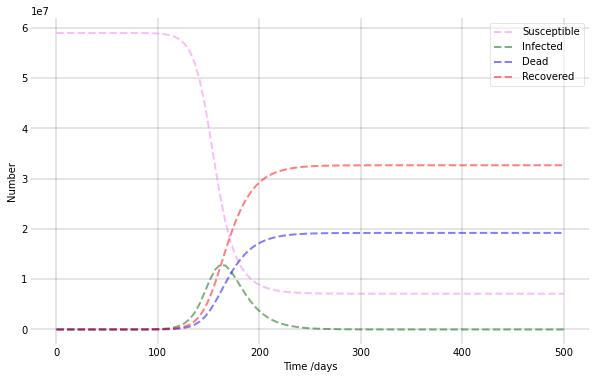

In [7]:
# Plot the data
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Susceptible', linestyle='dashed')
ax.plot(t, I, 'darkgreen', alpha=0.5, lw=2, label='Infected', linestyle='dashed')
ax.plot(t, D, 'blue', alpha=0.5, lw=2, label='Dead', linestyle='dashed')
ax.plot(t, R, 'red', alpha=0.5, lw=2, label='Recovered', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [8]:
data = np.asarray([t, S, I, D, R]) 

## DINN Implementation

In [9]:
class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        
        self.N = 59e6 #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        

        #matrices (x4 for S,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.gamma_tilda]))

    #force parameters to be in a range
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) #* 0.1 + 0.2

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) #* 0.01 + 0.05
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda) #* 0.01 + 0.03

    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
            
            #pass the timesteps batch to the neural network
            sidr_hat = self.net_sidr(t_batch)
            
            #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
            S_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3]

            #S_t
            sidr_hat.backward(self.m1, retain_graph=True)
            S_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I_t
            sidr_hat.backward(self.m2, retain_graph=True)
            I_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #D_t
            sidr_hat.backward(self.m3, retain_graph=True)
            D_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #R_t
            sidr_hat.backward(self.m4, retain_graph=True)
            R_hat_t = self.t.grad.clone()
            self.t.grad.zero_() 

            #unnormalize
            S = self.S_min + (self.S_max - self.S_min) * S_hat
            I = self.I_min + (self.I_max - self.I_min) * I_hat
            D = self.D_min + (self.D_max - self.D_min) * D_hat      
            R = self.R_min + (self.R_max - self.R_min) * R_hat        

            f1_hat = S_hat_t - (-(self.alpha / self.N) * S * I)  / (self.S_max - self.S_min)
            f2_hat = I_hat_t - ((self.alpha / self.N) * S * I - self.beta * I - self.gamma * I ) / (self.I_max - self.I_min)
            f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
            f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)        

            return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat

    def train(self, n_epochs):
        # train
        print('\nstarting training...\n')
        
        for epoch in range(n_epochs):
            # lists to hold the output (maintain only the final epoch)
            S_pred_list = []
            I_pred_list = []
            D_pred_list = []
            R_pred_list = []

            # we pass the timesteps batch into net_f
            f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch) # net_f outputs f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
            
            self.optimizer.zero_grad() #zero grad
            
            #append the values to plot later (note that we unnormalize them here for plotting)
            S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
            I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
            D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
            R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

            #calculate the loss --- MSE of the neural networks output and each compartment
            loss = (torch.mean(torch.square(self.S_hat - S_pred))+ 
                    torch.mean(torch.square(self.I_hat - I_pred))+
                    torch.mean(torch.square(self.D_hat - D_pred))+
                    torch.mean(torch.square(self.R_hat - R_pred))+
                    torch.mean(torch.square(f1))+
                    torch.mean(torch.square(f2))+
                    torch.mean(torch.square(f3))+
                    torch.mean(torch.square(f4))
                    ) 

            loss.backward()
            self.optimizer.step()
            self.scheduler.step() 

            # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
            self.losses.append(loss.item())

            if epoch % 1000 == 0:          
                print('\nEpoch ', epoch)
                print('alpha: (goal 0.191 ', self.alpha)
                print('beta: (goal 0.05 ', self.beta)
                print('gamma: (goal 0.0294 ', self.gamma)
                print('#################################')                

        return S_pred_list, I_pred_list, D_pred_list, R_pred_list

In [10]:
dinn = DINN(
    data[0],
    data[1],
    data[2],
    data[3], 
    data[4]
) #in the form of [t,S,I,D,R]

learning_rate = 1e-6
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(
    dinn.optimizer,
    base_lr=1e-5, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(50000) #train


starting training...


Epoch  0
alpha: (goal 0.191  tensor([0.0290], grad_fn=<TanhBackward0>)
beta: (goal 0.05  tensor([0.3816], grad_fn=<TanhBackward0>)
gamma: (goal 0.0294  tensor([0.2541], grad_fn=<TanhBackward0>)
#################################

Epoch  1000
alpha: (goal 0.191  tensor([0.0450], grad_fn=<TanhBackward0>)
beta: (goal 0.05  tensor([0.3683], grad_fn=<TanhBackward0>)
gamma: (goal 0.0294  tensor([0.2397], grad_fn=<TanhBackward0>)
#################################

Epoch  2000
alpha: (goal 0.191  tensor([0.0532], grad_fn=<TanhBackward0>)
beta: (goal 0.05  tensor([0.3603], grad_fn=<TanhBackward0>)
gamma: (goal 0.0294  tensor([0.2310], grad_fn=<TanhBackward0>)
#################################

Epoch  3000
alpha: (goal 0.191  tensor([0.0619], grad_fn=<TanhBackward0>)
beta: (goal 0.05  tensor([0.3508], grad_fn=<TanhBackward0>)
gamma: (goal 0.0294  tensor([0.2208], grad_fn=<TanhBackward0>)
#################################

Epoch  4000
alpha: (goal 0.191  tensor([0.0737], gr

(Text(0, 0.5, 'Loss'),)

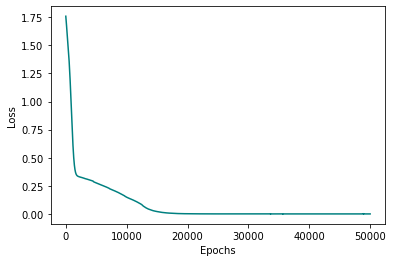

In [11]:
plt.plot(dinn.losses[0:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss'),

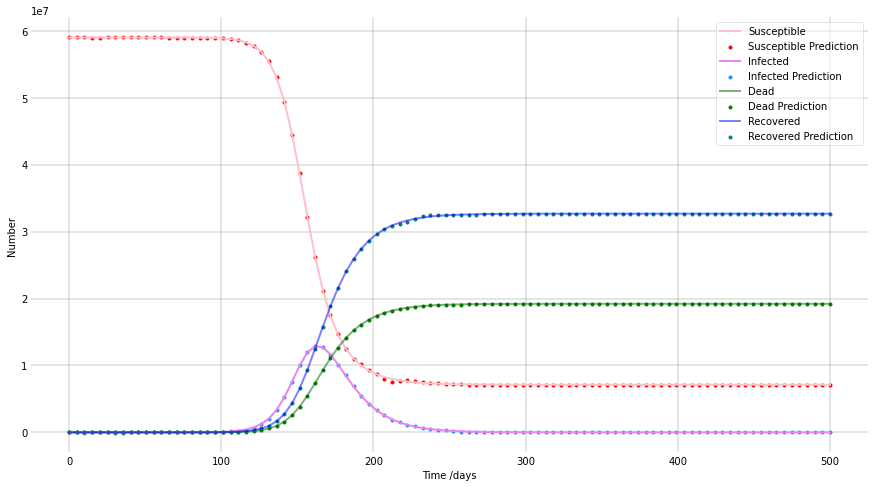

In [12]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(data[0], data[1], 'pink', alpha=1, lw=2, label='Susceptible')
ax.scatter(data[0], S_pred_list[0].detach().numpy(), color='red', marker=".", alpha=1 , label='Susceptible Prediction')

ax.plot(data[0], data[2], 'violet', alpha=1, lw=2, label='Infected')
ax.scatter(data[0], I_pred_list[0].detach().numpy(), color='dodgerblue', alpha=1, marker=".", label='Infected Prediction')

ax.plot(data[0], data[3], 'darkgreen', alpha=0.5, lw=2, label='Dead')
ax.scatter(data[0], D_pred_list[0].detach().numpy(), color='green', alpha=1, marker=".", label='Dead Prediction')

ax.plot(data[0], data[4], 'blue', alpha=0.5, lw=2, label='Recovered')
ax.scatter(data[0], R_pred_list[0].detach().numpy(), color='teal', alpha=1, marker=".", label='Recovered Prediction')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()